In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import time

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [72]:
t_max = 10
epsilon = 1e-6
N_t = 100
l=1.0

lr = 0.5e-3      # 0.5e-3
layers = 4       # 4
neuronas = 128   # 128
epocs = 15_000   # 15_000

In [73]:
# Modelo

class FunAct(nn.Module):
    def forward(self,x):
        return torch.tanh(x)


class MLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, width=neuronas, depth=layers):
        super().__init__()
        capas = [nn.Linear(in_dim, width), FunAct()]
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()]
        capas +=[nn.Linear(width, out_dim)]
        self.net=nn.Sequential(*capas)    

    def forward(self, x):
        return self.net(x)

In [74]:
u = MLP().to(device)

In [75]:
def D(y, x):
    return torch.autograd.grad(y,x, torch.ones_like(y), retain_graph = True, create_graph= True)[0]
def R(u,t):

    u_t = D(u,t)
    u_tt = D(u_t,t)

    return u + u_tt 

def u_forward(t):
    return u(t)


In [76]:
def muestreo(N):
    return torch.rand(N, 1, device=device)*(t_max)

In [77]:
optimizador = torch.optim.Adam(u.parameters(), lr)

In [78]:
tiempo_0 = time.time()

loss_valores = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizador, factor=0.5, patience=200)

for step in range(epocs):

    optimizador.zero_grad()

    t_i = muestreo(N_t).clone().detach().requires_grad_()
    #u_i = u_forward(t_i)
    R_i = R(u(t_i),t_i)
    
    # Condiciones de borde (CB): u(0) = ℓ
    t0 = torch.tensor([[0.0]], device=device, requires_grad=True)
    u_t0 = D(u(t0),t0)
    
    u0 = u(t0)  # debería valer ℓ
    

    # Definir la pérdida asociada a esas condiciones
    cb_loss = ((u0 - torch.tensor([[1.0]], device=device, requires_grad=False)*l)**2).mean()

    ci_loss = ((u_t0 - torch.tensor([[0.0]], device=device, requires_grad=False))**2).mean()


    loss = (R_i*R_i).mean() + cb_loss + ci_loss

    loss_valores.append(loss.item())

    loss.backward()

    optimizador.step()
    
    #scheduler.step(loss.item())

    if step % 1000 == 0:
        print(f"step {step:4d} | loss {loss.item():.3e} | {step*100/epocs}% {int((abs(tiempo_0-time.time())*abs(epocs-step)/(step+0.00000001))/60)} minutos restantes")


step    0 | loss 7.019e-01 | 0.0% 521600246 minutos restantes
step 1000 | loss 2.186e-02 | 6.666666666666667% 2 minutos restantes
step 2000 | loss 2.225e-02 | 13.333333333333334% 1 minutos restantes
step 3000 | loss 1.068e-02 | 20.0% 1 minutos restantes
step 4000 | loss 5.360e-05 | 26.666666666666668% 1 minutos restantes
step 5000 | loss 5.341e-05 | 33.333333333333336% 1 minutos restantes
step 6000 | loss 3.116e-03 | 40.0% 1 minutos restantes
step 7000 | loss 1.451e-05 | 46.666666666666664% 1 minutos restantes
step 8000 | loss 4.991e-04 | 53.333333333333336% 1 minutos restantes
step 9000 | loss 5.484e-05 | 60.0% 0 minutos restantes
step 10000 | loss 3.692e-05 | 66.66666666666667% 0 minutos restantes
step 11000 | loss 1.545e-04 | 73.33333333333333% 0 minutos restantes
step 12000 | loss 9.890e-05 | 80.0% 0 minutos restantes
step 13000 | loss 2.498e-04 | 86.66666666666667% 0 minutos restantes
step 14000 | loss 5.116e-06 | 93.33333333333333% 0 minutos restantes


Text(0.5, 1.0, 'loss')

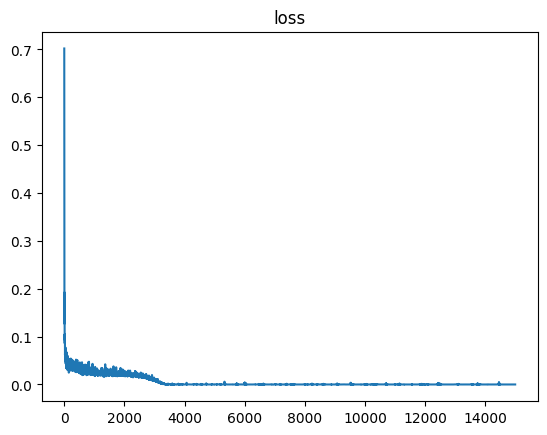

In [79]:
plt.plot(loss_valores)
plt.title('loss')

Text(0, 0.5, 'Loss')

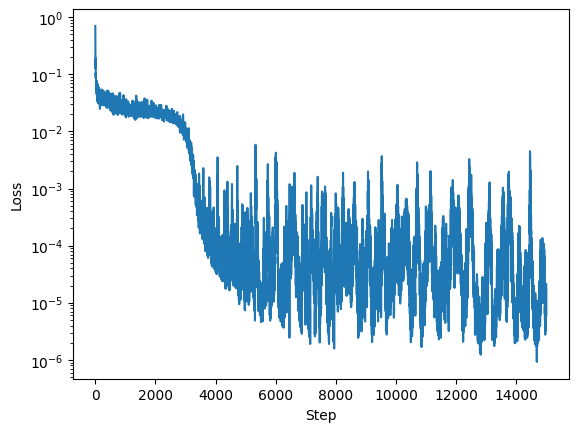

In [80]:
import matplotlib.pyplot as plt
plt.plot(loss_valores)
plt.yscale('log')  # si baja exponencialmente
plt.xlabel("Step"); plt.ylabel("Loss")


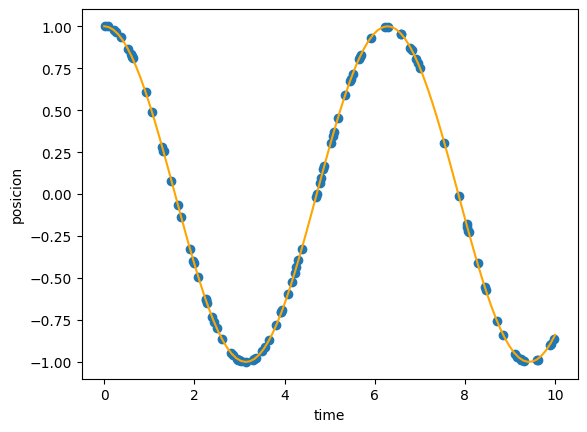

In [82]:
with torch.no_grad():
    t_g = muestreo(N_t).clone().detach().requires_grad_()

    t_vals = t_g.detach().cpu().numpy()
    u_vals = u(t_g).detach().cpu().numpy()

def u_esacta(t):
    return np.cos(t)*l

t_poblado = np.linspace(0,10,len(t_vals))

plt.scatter(t_vals,u_vals)
plt.plot(t_poblado,u_esacta(t_poblado),'orange')
plt.xlabel('time')
plt.ylabel('posicion')
plt.show()